In [1356]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

df = pd.read_csv('lstm_data.csv', index_col='Month', parse_dates=True)
df = df[['Median Price', 'CPI_Can', 'Inflation', 'Bank_Rate', 'CAN_Mort_Lending_Rate5yr', 'Mortgage_Var_Rate', 'Mortgage_Fixed_Rate_5yr', 'Bond_1-3yr_Avg']]   
df

,Median Price,CPI_Can,Inflation,Bank_Rate,CAN_Mort_Lending_Rate5yr,Mortgage_Var_Rate,Mortgage_Fixed_Rate_5yr,Bond_1-3yr_Avg
Month,,,,,,,,
2013-01-01,413500,121.3,1.3,1.25,4.14,3.57,3.00,1.16
2013-02-01,434000,122.7,1.5,1.25,4.11,3.52,2.98,1.12
2013-03-01,441000,122.9,1.5,1.25,4.02,3.51,2.99,1.01
2013-04-01,453500,122.7,1.2,1.25,4.02,3.52,2.99,1.00
2013-05-01,478500,123.0,1.2,1.25,4.02,3.50,2.96,1.04
...,...,...,...,...,...,...,...,...
2023-01-01,797500,153.9,6.4,4.50,5.86,6.31,5.25,3.83
2023-02-01,850000,154.5,6.2,4.75,5.81,6.35,5.14,4.09
2023-03-01,850000,155.3,5.9,4.75,5.81,6.59,5.09,3.87


## SINGLE STEP LSTM w EXO

In [1233]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(1)
set_seed(2)

In [1357]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

window_size = 60
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(window_size, X.shape[2])))
model.add(LSTM(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=50, batch_size=32)
 
y_pred = model.predict(X_test)

Epoch 1/50
2/2 [==============================] - 2s 52ms/step - loss: 0.2341
Epoch 2/50
2/2 [==============================] - 0s 28ms/step - loss: 0.1580
Epoch 3/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0947
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0461
Epoch 5/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0157
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0140
Epoch 7/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0252
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0323
Epoch 9/50
2/2 [==============================] - 0s 38ms/step - loss: 0.0275
Epoch 10/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0184
Epoch 11/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0114
Epoch 12/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0088
Epoch 13/50
2/2 [==============================] - 0s 35ms/st

In [1163]:
model.summary()

Model: "sequential_329"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_649 (LSTM)             (None, 48, 20)            2320      
                                                                 
 lstm_650 (LSTM)             (None, 20)                3280      
                                                                 
 dense_336 (Dense)           (None, 1)                 21        
                                                                 
Total params: 5,621
Trainable params: 5,621
Non-trainable params: 0
_________________________________________________________________


In [1203]:
# Predict Q1 of 2021 ST X
start_date = '2021-01-01'
end_date = '2021-03-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2021Q1 = model.predict(X)
y_pred_orig_2021Q1 = np.zeros((len(y_pred_2021Q1), df.shape[1]))
y_pred_orig_2021Q1[:, 0] = y_pred_2021Q1[:, 0]
y_pred_orig_2021Q1 = scaler.inverse_transform(y_pred_orig_2021Q1)[:, 0]
y_pred_orig_2021Q1

1/1 [==============================] - 0s 27ms/step


array([802515.98128676, 803848.45641255, 805207.70800114])

In [1210]:
# Predict Q2 of 2021 ST X
start_date = '2021-04-01'
end_date = '2021-06-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2021Q2 = model.predict(X)
y_pred_orig_2021Q2 = np.zeros((len(y_pred_2021Q2), df.shape[1]))
y_pred_orig_2021Q2[:, 0] = y_pred_2021Q2[:, 0]
y_pred_orig_2021Q2 = scaler.inverse_transform(y_pred_orig_2021Q2)[:, 0]
y_pred_orig_2021Q2

1/1 [==============================] - 0s 21ms/step


array([829469.78327632, 835054.92120981, 841444.26470995])

In [1241]:
# Predict Q3 of 2021 ST X
start_date = '2021-07-01'
end_date = '2021-09-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2021Q3 = model.predict(X)
y_pred_orig_2021Q3 = np.zeros((len(y_pred_2021Q3), df.shape[1]))
y_pred_orig_2021Q3[:, 0] = y_pred_2021Q3[:, 0]
y_pred_orig_2021Q3 = scaler.inverse_transform(y_pred_orig_2021Q3)[:, 0]
y_pred_orig_2021Q3

1/1 [==============================] - 0s 25ms/step


array([822578.98044586, 829817.87729263, 836728.09559107])

In [1358]:
# Predict Q4 of 2021 ST X
start_date = '2021-10-01'
end_date = '2021-12-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2021Q4 = model.predict(X)
y_pred_orig_2021Q4 = np.zeros((len(y_pred_2021Q4), df.shape[1]))
y_pred_orig_2021Q4[:, 0] = y_pred_2021Q4[:, 0]
y_pred_orig_2021Q4 = scaler.inverse_transform(y_pred_orig_2021Q4)[:, 0]
y_pred_orig_2021Q4

1/1 [==============================] - 0s 25ms/step


array([859592.08834171, 864564.67670202, 868874.64046478])

In [1168]:
# Predict the entire year of 2021
start_date = '2021-01-01'
end_date = '2021-12-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2021 = model.predict(X)

1/1 [==============================] - 0s 27ms/step


In [1169]:
y_pred_orig_2021 = np.zeros((len(y_pred_2021), df.shape[1]))
y_pred_orig_2021[:, 0] = y_pred_2021[:, 0]
y_pred_orig_2021 = scaler.inverse_transform(y_pred_orig_2021)[:, 0]
y_pred_orig_2021

array([803916.59626365, 803671.08345032, 803346.55812383, 805273.24786782,
       808948.00505042, 814370.32318115, 820209.58426595, 825938.12653422,
       831060.9062016 , 836739.20461535, 843128.04162502, 849765.59922099])

In [1029]:
# Predict the entire year of 2020
start_date = '2020-01-01'
end_date = '2020-12-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2020 = model.predict(X)

1/1 [==============================] - 0s 23ms/step


In [1030]:
y_pred_orig_2020 = np.zeros((len(y_pred_2020), df.shape[1]))
y_pred_orig_2020[:, 0] = y_pred_2020[:, 0]
y_pred_orig_2020 = scaler.inverse_transform(y_pred_orig_2020)[:, 0]
y_pred_orig_2020

array([760792.10683703, 773429.48299646, 783418.48802567, 790965.73626995,
       793230.39022088, 792276.16217732, 792696.07654214, 796030.33706546,
       801289.32890296, 803249.48078394, 805664.25850987, 809774.25983548])

In [1079]:
# Predict the entire year of 2022
start_date = '2022-01-01'
end_date = '2022-12-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2020 = model.predict(X)

1/1 [==============================] - 0s 27ms/step


In [1080]:
y_pred_orig_2022 = np.zeros((len(y_pred_2022), df.shape[1]))
y_pred_orig_2022[:, 0] = y_pred_2022[:, 0]
y_pred_orig_2022 = scaler.inverse_transform(y_pred_orig_2022)[:, 0]
y_pred_orig_2022

array([860519.84381676, 872281.59925342, 879955.0986886 , 884050.04036427,
       889448.41837883, 895714.04314041, 903313.49366903, 911462.65518665,
       918811.3591671 , 920328.1968236 , 920625.43919682, 922170.74161768])

In [1313]:
# Predict Q1 of 2022 ST X
start_date = '2022-01-01'
end_date = '2022-03-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q1 = model.predict(X)
y_pred_orig_2022Q1 = np.zeros((len(y_pred_2022Q1), df.shape[1]))
y_pred_orig_2022Q1[:, 0] = y_pred_2022Q1[:, 0]
y_pred_orig_2022Q1 = scaler.inverse_transform(y_pred_orig_2022Q1)[:, 0]
y_pred_orig_2022Q1

1/1 [==============================] - 0s 25ms/step


array([865908.53098035, 870940.68261981, 877222.61637449])

In [1351]:
# Predict Q2 of 2022 ST X
start_date = '2022-04-01'
end_date = '2022-06-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q2 = model.predict(X)
y_pred_orig_2022Q2 = np.zeros((len(y_pred_2022Q2), df.shape[1]))
y_pred_orig_2022Q2[:, 0] = y_pred_2022Q2[:, 0]
y_pred_orig_2022Q2 = scaler.inverse_transform(y_pred_orig_2022Q2)[:, 0]
y_pred_orig_2022Q2

1/1 [==============================] - 0s 27ms/step


array([919890.21763206, 928233.70265961, 936934.46606398])

In [1348]:
# Predict Q3 of 2022 ST X
start_date = '2022-07-01'
end_date = '2022-09-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q3 = model.predict(X)
y_pred_orig_2022Q3 = np.zeros((len(y_pred_2022Q3), df.shape[1]))
y_pred_orig_2022Q3[:, 0] = y_pred_2022Q3[:, 0]
y_pred_orig_2022Q3 = scaler.inverse_transform(y_pred_orig_2022Q3)[:, 0]
y_pred_orig_2022Q3

1/1 [==============================] - 0s 25ms/step


array([867046.91895843, 865024.84017611, 861569.32583451])

In [1317]:
# Predict Q4 of 2022 ST X
start_date = '2022-10-01'
end_date = '2022-12-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    # Get the past window_size values for all variables
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q4 = model.predict(X)
y_pred_orig_2022Q4 = np.zeros((len(y_pred_2022Q4), df.shape[1]))
y_pred_orig_2022Q4[:, 0] = y_pred_2022Q4[:, 0]
y_pred_orig_2022Q4 = scaler.inverse_transform(y_pred_orig_2022Q4)[:, 0]
y_pred_orig_2022Q4

1/1 [==============================] - 0s 25ms/step


array([898562.34294176, 894881.60917163, 890866.0852015 ])

## single step without exo

In [1360]:
df2 = pd.read_csv('lstm_data.csv', index_col='Month', parse_dates=True)
df2 = df2[['Median Price']]   
df2

,Median Price
Month,
2013-01-01,413500
2013-02-01,434000
2013-03-01,441000
2013-04-01,453500
2013-05-01,478500
...,...
2023-01-01,797500
2023-02-01,850000
2023-03-01,850000


In [1361]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df2)

window_size = 60
X, y = [], []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
2/2 [==============================] - 2s 51ms/step - loss: 0.4243
Epoch 2/50
2/2 [==============================] - 0s 27ms/step - loss: 0.3183
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2322
Epoch 4/50
2/2 [==============================] - 0s 29ms/step - loss: 0.1601
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0961
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0492
Epoch 7/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0174
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0091
Epoch 9/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0177
Epoch 10/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0305
Epoch 11/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0335
Epoch 12/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0267
Epoch 13/50
2/2 [==============================] - 0s 27ms/st

In [1320]:
# Predict Q1 of 2022 ST no X
start_date = '2022-01-01'
end_date = '2022-03-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df2.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q1 = model.predict(X)
y_pred_orig_2022Q1 = np.zeros((len(y_pred_2022Q1), df2.shape[1]))
y_pred_orig_2022Q1[:, 0] = y_pred_2022Q1[:, 0]
y_pred_orig_2022Q1 = scaler.inverse_transform(y_pred_orig_2022Q1)[:, 0]
y_pred_orig_2022Q1

1/1 [==============================] - 0s 494ms/step


array([838510.13165712, 840783.63230824, 844267.94907451])

In [1322]:
# Predict Q2 of 2022 ST no X
start_date = '2022-04-01'
end_date = '2022-06-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df2.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q2 = model.predict(X)
y_pred_orig_2022Q2 = np.zeros((len(y_pred_2022Q2), df2.shape[1]))
y_pred_orig_2022Q2[:, 0] = y_pred_2022Q2[:, 0]
y_pred_orig_2022Q2 = scaler.inverse_transform(y_pred_orig_2022Q2)[:, 0]
y_pred_orig_2022Q2

1/1 [==============================] - 0s 26ms/step


array([849214.26746249, 855270.88049054, 862108.23169351])

In [1355]:
# Predict Q3 of 2022 ST no X
start_date = '2022-07-01'
end_date = '2022-09-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df2.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q3 = model.predict(X)
y_pred_orig_2022Q3 = np.zeros((len(y_pred_2022Q3), df2.shape[1]))
y_pred_orig_2022Q3[:, 0] = y_pred_2022Q3[:, 0]
y_pred_orig_2022Q3 = scaler.inverse_transform(y_pred_orig_2022Q3)[:, 0]
y_pred_orig_2022Q3

1/1 [==============================] - 1s 521ms/step


array([873483.56866837, 878611.75090075, 881744.32691932])

In [1362]:
# Predict Q4 of 2022 ST no X
start_date = '2022-10-01'
end_date = '2022-12-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df2.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q4 = model.predict(X)
y_pred_orig_2022Q4 = np.zeros((len(y_pred_2022Q4), df2.shape[1]))
y_pred_orig_2022Q4[:, 0] = y_pred_2022Q4[:, 0]
y_pred_orig_2022Q4 = scaler.inverse_transform(y_pred_orig_2022Q4)[:, 0]
y_pred_orig_2022Q4

1/1 [==============================] - 1s 541ms/step


array([896253.75938416, 897477.40659118, 897634.45240259])

In [1084]:
y_pred_orig_2022 = np.zeros((len(y_pred_2022), df2.shape[1]))
y_pred_orig_2022[:, 0] = y_pred_2022[:, 0]
y_pred_orig_2022 = scaler.inverse_transform(y_pred_orig_2022)[:, 0]
y_pred_orig_2022

array([873615.28995633, 888939.02403116, 898252.77596712, 902030.31694889,
       907128.14351916, 913319.14535165, 921832.84494281, 932296.33024335,
       942782.97904134, 945645.49434185, 946484.10749435, 949050.22457242])

In [1171]:
# Predict Q1 2021 no X 
start_date = '2021-01-01'
end_date = '2021-03-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df2.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2021Q1 = model.predict(X)
y_pred_orig_2021Q1 = np.zeros((len(y_pred_2021Q1), df2.shape[1]))
y_pred_orig_2021Q1[:, 0] = y_pred_2021Q1[:, 0]
y_pred_orig_2021Q1 = scaler.inverse_transform(y_pred_orig_2021Q1)[:, 0]
y_pred_orig_2021Q1

1/1 [==============================] - 1s 508ms/step


array([802735.73061824, 800823.93169403, 800090.22960067])

In [1214]:
# Predict Q2 2021 no X 
start_date = '2021-04-01'
end_date = '2021-06-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df2.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2021Q2 = model.predict(X)
y_pred_orig_2021Q2 = np.zeros((len(y_pred_2021Q2), df2.shape[1]))
y_pred_orig_2021Q2[:, 0] = y_pred_2021Q2[:, 0]
y_pred_orig_2021Q2 = scaler.inverse_transform(y_pred_orig_2021Q2)[:, 0]
y_pred_orig_2021Q2

1/1 [==============================] - 1s 512ms/step


array([794011.09462976, 796840.28285742, 801145.82327008])

In [1255]:
# Predict Q3 2021 no X 
start_date = '2021-07-01'
end_date = '2021-09-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df2.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2021Q3 = model.predict(X)
y_pred_orig_2021Q3 = np.zeros((len(y_pred_2021Q3), df2.shape[1]))
y_pred_orig_2021Q3[:, 0] = y_pred_2021Q3[:, 0]
y_pred_orig_2021Q3 = scaler.inverse_transform(y_pred_orig_2021Q3)[:, 0]
y_pred_orig_2021Q3

1/1 [==============================] - 1s 530ms/step


array([818287.4867022 , 822245.97984552, 825396.58692479])

In [1265]:
# Predict Q4 2021 no X 
start_date = '2021-10-01'
end_date = '2021-12-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df2.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2021Q4 = model.predict(X)
y_pred_orig_2021Q4 = np.zeros((len(y_pred_2021Q4), df2.shape[1]))
y_pred_orig_2021Q4[:, 0] = y_pred_2021Q4[:, 0]
y_pred_orig_2021Q4 = scaler.inverse_transform(y_pred_orig_2021Q4)[:, 0]
y_pred_orig_2021Q4

1/1 [==============================] - 0s 500ms/step


array([853732.36504197, 858567.42435694, 863218.49256754])

In [1074]:
# Predict the entire year of 2021
start_date = '2021-01-01'
end_date = '2021-12-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df2.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2021 = model.predict(X)

1/1 [==============================] - 1s 508ms/step


In [1075]:
y_pred_orig_2021 = np.zeros((len(y_pred_2021), df2.shape[1]))
y_pred_orig_2021[:, 0] = y_pred_2021[:, 0]
y_pred_orig_2021 = scaler.inverse_transform(y_pred_orig_2021)[:, 0]
y_pred_orig_2021

array([828659.80371833, 827903.98487449, 823268.21267605, 821673.2404232 ,
       826661.66505218, 831931.32695556, 836344.47970986, 840284.80672836,
       842149.80593324, 843991.50657654, 847802.17203498, 853999.92707372])

In [1042]:
# Predict the entire year of 2020
start_date = '2020-01-01'
end_date = '2020-12-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df2.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2020 = model.predict(X)

1/1 [==============================] - 0s 20ms/step


In [1043]:
y_pred_orig_2020 = np.zeros((len(y_pred_2020), df2.shape[1]))
y_pred_orig_2020[:, 0] = y_pred_2020[:, 0]
y_pred_orig_2020 = scaler.inverse_transform(y_pred_orig_2020)[:, 0]
y_pred_orig_2020

array([746110.97410321, 753312.93091178, 759978.78444195, 767679.0265739 ,
       771673.07534814, 774285.99214554, 779606.91088438, 788434.7358644 ,
       799208.09203386, 807053.56186628, 814519.83916759, 821717.74405241])

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_value = mape(y_test, y_pred)

rmse_value = np.sqrt(mean_squared_error(y_test, y_pred))

## OPTIMAL NEURONS TEST 

Epoch 1/50
3/3 [==============================] - 2s 16ms/step - loss: 0.2624
Epoch 2/50
3/3 [==============================] - 0s 14ms/step - loss: 0.2257
Epoch 3/50
3/3 [==============================] - 0s 10ms/step - loss: 0.1935
Epoch 4/50
3/3 [==============================] - 0s 7ms/step - loss: 0.1663
Epoch 5/50
3/3 [==============================] - 0s 8ms/step - loss: 0.1422
Epoch 6/50
3/3 [==============================] - 0s 8ms/step - loss: 0.1216
Epoch 7/50
3/3 [==============================] - 0s 7ms/step - loss: 0.1020
Epoch 8/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0848
Epoch 9/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0697
Epoch 10/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0563
Epoch 11/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0454
Epoch 12/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0368
Epoch 13/50
3/3 [==============================] - 0s 10ms/step - loss

3/3 [==============================] - 0s 8ms/step - loss: 0.0400
Epoch 5/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0296
Epoch 6/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0210
Epoch 7/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0190
Epoch 8/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0165
Epoch 9/50
3/3 [==============================] - 0s 7ms/step - loss: 0.0114
Epoch 10/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0084
Epoch 11/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0080
Epoch 12/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 13/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 14/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0069
Epoch 15/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0064
Epoch 16/50
3/3 [==============================] - 0s 7ms/step - loss: 0.0064
Epo

3/3 [==============================] - 0s 8ms/step - loss: 0.0163
Epoch 9/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0112
Epoch 10/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0077
Epoch 11/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0082
Epoch 12/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 13/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0054
Epoch 14/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0062
Epoch 15/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 16/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 17/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 18/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0055
Epoch 19/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 20/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0054

3/3 [==============================] - 0s 9ms/step - loss: 0.0069
Epoch 12/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0059
Epoch 13/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0057
Epoch 14/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0058
Epoch 15/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 16/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0054
Epoch 17/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 18/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0051
Epoch 19/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0053
Epoch 20/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 21/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0051
Epoch 22/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0050
Epoch 23/50
3/3 [==============================] - 0s 9ms/step - loss: 0.005

3/3 [==============================] - 0s 10ms/step - loss: 0.0057
Epoch 15/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0059
Epoch 16/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 17/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0052
Epoch 18/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0054
Epoch 19/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0052
Epoch 20/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0055
Epoch 21/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0052
Epoch 22/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0052
Epoch 23/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0052
Epoch 24/50
3/3 [==============================] - 0s 11ms/step - loss: 0.0052
Epoch 25/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0051
Epoch 26/50
3/3 [==============================] - 0s 10ms/step 

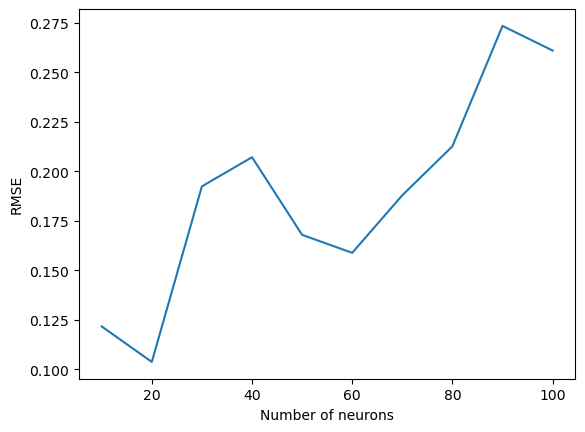

In [100]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import numpy as np

def build_and_train_model(neurons, X_train, y_train, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(window_size, X.shape[2])))
    model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    return model

neurons_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
rmse_values = []
for neurons in neurons_list:
    model = build_and_train_model(neurons, X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    y_pred_orig = np.zeros((len(y_pred), df.shape[1]))
    y_pred_orig[:, 0] = y_pred[:, 0]
    y_pred_orig = scaler.inverse_transform(y_pred_orig)[:, 0]
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_values.append(rmse)

import matplotlib.pyplot as plt
plt.plot(neurons_list, rmse_values)
plt.xlabel('Number of neurons')
plt.ylabel('RMSE')
plt.show()


In [ ]:
y_pred

In [ ]:
y_test

# MULTI STEP LSTM

## multistep w EXO 

In [1365]:


import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

df = pd.read_csv('lstm_data.csv', index_col='Month', parse_dates=True)
df['month'] = df.index.month
df = df[['Median Price', 'CPI_Can', 'Inflation', 'Bank_Rate', 'CAN_Mort_Lending_Rate5yr', 'Mortgage_Var_Rate', 'Mortgage_Fixed_Rate_5yr', 'Bond_1-3yr_Avg', 'month']]   
df

,Median Price,CPI_Can,Inflation,Bank_Rate,CAN_Mort_Lending_Rate5yr,Mortgage_Var_Rate,Mortgage_Fixed_Rate_5yr,Bond_1-3yr_Avg,month
Month,,,,,,,,,
2013-01-01,413500,121.3,1.3,1.25,4.14,3.57,3.00,1.16,1
2013-02-01,434000,122.7,1.5,1.25,4.11,3.52,2.98,1.12,2
2013-03-01,441000,122.9,1.5,1.25,4.02,3.51,2.99,1.01,3
2013-04-01,453500,122.7,1.2,1.25,4.02,3.52,2.99,1.00,4
2013-05-01,478500,123.0,1.2,1.25,4.02,3.50,2.96,1.04,5
...,...,...,...,...,...,...,...,...,...
2023-01-01,797500,153.9,6.4,4.50,5.86,6.31,5.25,3.83,1
2023-02-01,850000,154.5,6.2,4.75,5.81,6.35,5.14,4.09,2
2023-03-01,850000,155.3,5.9,4.75,5.81,6.59,5.09,3.87,3


In [1243]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

window_size = 48
horizons = [12]

X, Ys = [], [[] for _ in horizons]
for i in range(window_size, len(scaled_data) - max(horizons)):
    X.append(scaled_data[i-window_size:i])
    for j, horizon in enumerate(horizons):
        Ys[j].append(scaled_data[i:i+horizon, 0])
X = np.array(X)
Ys = [np.array(Y) for Y in Ys]

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_trains, Y_tests = [], []
for Y in Ys:
    Y_train, Y_test = Y[:split], Y[split:]
    Y_trains.append(Y_train)
    Y_tests.append(Y_test)

models = []
for horizon, Y_train in zip(horizons, Y_trains):
    model = Sequential()
    model.add(LSTM(30, return_sequences=True, input_shape=(window_size, X.shape[2])))
    model.add(LSTM(30))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=50, batch_size=32)
    models.append(model)

for horizon, model in zip(horizons, models):
    model.save(f'lstm_model_{horizon}.h5')

Y_preds = []
for model in models:
    Y_pred = model.predict(X_test)
    Y_preds.append(Y_pred)

time_periods = [ # last 4 months of 2022
    ('2020-01-01', '2020-12-01') # last 12 months of 2022
]
input_seqs = []
for start_date, end_date in time_periods:
    start_idx = df.index.get_loc(start_date) - window_size
    end_idx = df.index.get_loc(end_date)
    if start_idx < 0:
        print(f'Not enough data for date range {start_date} to {end_date}')
        continue
    input_seq = scaled_data[start_idx:end_idx][-window_size:]
    input_seq = input_seq.reshape((1, window_size, -1))
    input_seqs.append(input_seq)


models = []
for horizon in horizons:
    model = load_model(f'lstm_model_{horizon}.h5')
    models.append(model)

Y_preds = []
for input_seq in input_seqs:
    y_preds = []
    for model in models:
        y_pred = model.predict(input_seq)
        y_preds.append(y_pred)
    Y_preds.append(y_preds)

Epoch 1/50
2/2 [==============================] - 2s 47ms/step - loss: 0.3504
Epoch 2/50
2/2 [==============================] - 0s 25ms/step - loss: 0.3152
Epoch 3/50
2/2 [==============================] - 0s 23ms/step - loss: 0.2858
Epoch 4/50
2/2 [==============================] - 0s 24ms/step - loss: 0.2587
Epoch 5/50
2/2 [==============================] - 0s 25ms/step - loss: 0.2293
Epoch 6/50
2/2 [==============================] - 0s 25ms/step - loss: 0.1975
Epoch 7/50
2/2 [==============================] - 0s 25ms/step - loss: 0.1638
Epoch 8/50
2/2 [==============================] - 0s 25ms/step - loss: 0.1334
Epoch 9/50
2/2 [==============================] - 0s 24ms/step - loss: 0.1126
Epoch 10/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0956
Epoch 11/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0785
Epoch 12/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0616
Epoch 13/50
2/2 [==============================] - 0s 27ms/st

In [1013]:
Y_preds

[[array([[0.6596868 , 0.6364569 , 0.62981   , 0.70192254, 0.67709357,
          0.64061785, 0.66132414, 0.6878917 , 0.684299  , 0.7262048 ,
          0.6658412 , 0.7178532 ]], dtype=float32)]]

In [1014]:
y_pred_2020_ms_RS = Y_preds[0][0].reshape((-1, 1))
y_pred_orig_2020_ms = np.zeros((len(y_pred_2020_ms_RS), df.shape[1]))
y_pred_orig_2020_ms[:, 0] = y_pred_2020_ms_RS[:, 0]
y_pred_orig_2020_ms = scaler.inverse_transform(y_pred_orig_2020_ms)[:, 0]
y_pred_orig_2020_ms

array([787212.57436275, 774052.83769965, 770287.35119104, 811139.11658525,
       797073.50483537, 776410.01057625, 788140.12724161, 803190.66035748,
       801155.37905693, 824895.02629638, 790699.05215502, 820163.83129358])

In [1069]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

window_size = 48
horizons = [12]

X, Ys = [], [[] for _ in horizons]
for i in range(window_size, len(scaled_data) - max(horizons)):
    X.append(scaled_data[i-window_size:i])
    for j, horizon in enumerate(horizons):
        Ys[j].append(scaled_data[i:i+horizon, 0])
X = np.array(X)
Ys = [np.array(Y) for Y in Ys]

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_trains, Y_tests = [], []
for Y in Ys:
    Y_train, Y_test = Y[:split], Y[split:]
    Y_trains.append(Y_train)
    Y_tests.append(Y_test)

models = []
for horizon, Y_train in zip(horizons, Y_trains):
    model = Sequential()
    model.add(LSTM(30, return_sequences=True, input_shape=(window_size, X.shape[2])))
    model.add(LSTM(30))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=50, batch_size=32)
    models.append(model)

for horizon, model in zip(horizons, models):
    model.save(f'lstm_model_{horizon}.h5')

Y_preds = []
for model in models:
    Y_pred = model.predict(X_test)
    Y_preds.append(Y_pred)

time_periods = [ # last 4 months of 2022
    ('2021-01-01', '2021-12-01') # last 12 months of 2022
]
input_seqs = []
for start_date, end_date in time_periods:
    start_idx = df.index.get_loc(start_date) - window_size
    end_idx = df.index.get_loc(end_date)
    if start_idx < 0:
        print(f'Not enough data for date range {start_date} to {end_date}')
        continue
    input_seq = scaled_data[start_idx:end_idx][-window_size:]
    input_seq = input_seq.reshape((1, window_size, -1))
    input_seqs.append(input_seq)


models = []
for horizon in horizons:
    model = load_model(f'lstm_model_{horizon}.h5')
    models.append(model)

Y_preds = []
for input_seq in input_seqs:
    y_preds = []
    for model in models:
        y_pred = model.predict(input_seq)
        y_preds.append(y_pred)
    Y_preds.append(y_preds)

Epoch 1/50
2/2 [==============================] - 2s 47ms/step - loss: 0.2850
Epoch 2/50
2/2 [==============================] - 0s 23ms/step - loss: 0.2504
Epoch 3/50
2/2 [==============================] - 0s 24ms/step - loss: 0.2159
Epoch 4/50
2/2 [==============================] - 0s 25ms/step - loss: 0.1834
Epoch 5/50
2/2 [==============================] - 0s 25ms/step - loss: 0.1529
Epoch 6/50
2/2 [==============================] - 0s 31ms/step - loss: 0.1277
Epoch 7/50
2/2 [==============================] - 0s 25ms/step - loss: 0.1072
Epoch 8/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0890
Epoch 9/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0720
Epoch 10/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0560
Epoch 11/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0444
Epoch 12/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0366
Epoch 13/50
2/2 [==============================] - 0s 25ms/st

In [1070]:
Y_preds

[[array([[0.62253517, 0.68294984, 0.6838406 , 0.7141911 , 0.64804506,
          0.7245905 , 0.68127936, 0.5871307 , 0.7021383 , 0.72991395,
          0.7368447 , 0.7141205 ]], dtype=float32)]]

In [1071]:
y_pred_2021_ms_RS = Y_preds[0][0].reshape((-1, 1))
y_pred_orig_2021_ms = np.zeros((len(y_pred_2021_ms_RS), df.shape[1]))
y_pred_orig_2021_ms[:, 0] = y_pred_2021_ms_RS[:, 0]
y_pred_orig_2021_ms = scaler.inverse_transform(y_pred_orig_2021_ms)[:, 0]
y_pred_orig_2021_ms

array([766166.17330909, 800391.08493924, 800895.68451047, 818089.24633265,
       780617.52820015, 823980.50710559, 799444.758147  , 746109.5559299 ,
       811261.34961843, 826996.25265598, 830922.53300548, 818049.26735163])

In [1308]:
# 2021 Qaurters 

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

window_size = 24
horizons = [3]

X, Ys = [], [[] for _ in horizons]
for i in range(window_size, len(scaled_data) - max(horizons)):
    X.append(scaled_data[i-window_size:i])
    for j, horizon in enumerate(horizons):
        Ys[j].append(scaled_data[i:i+horizon, 0])
X = np.array(X)
Ys = [np.array(Y) for Y in Ys]

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_trains, Y_tests = [], []
for Y in Ys:
    Y_train, Y_test = Y[:split], Y[split:]
    Y_trains.append(Y_train)
    Y_tests.append(Y_test)

models = []
for horizon, Y_train in zip(horizons, Y_trains):
    model = Sequential()
    model.add(LSTM(40, return_sequences=True, input_shape=(window_size, X.shape[2])))
    model.add(LSTM(40))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=50, batch_size=32)
    models.append(model)

for horizon, model in zip(horizons, models):
    model.save(f'lstm_model_{horizon}.h5')

Y_preds = []
for model in models:
    Y_pred = model.predict(X_test)
    Y_preds.append(Y_pred)

time_periods = [ 
    ('2021-01-01', '2021-03-01'), 
    ('2021-04-01', '2021-06-01'), 
    ('2021-07-01', '2021-09-01'), 
    ('2021-10-01', '2021-12-01')
]
input_seqs = []
for start_date, end_date in time_periods:
    start_idx = df.index.get_loc(start_date) - window_size
    end_idx = df.index.get_loc(end_date)
    if start_idx < 0:
        print(f'Not enough data for date range {start_date} to {end_date}')
        continue
    input_seq = scaled_data[start_idx:end_idx][-window_size:]
    input_seq = input_seq.reshape((1, window_size, -1))
    input_seqs.append(input_seq)


models = []
for horizon in horizons:
    model = load_model(f'lstm_model_{horizon}.h5')
    models.append(model)

Y_preds = []
for input_seq in input_seqs:
    y_preds = []
    for model in models:
        y_pred = model.predict(input_seq)
        y_preds.append(y_pred)
    Y_preds.append(y_preds)

Epoch 1/50
3/3 [==============================] - 2s 23ms/step - loss: 0.2176
Epoch 2/50
3/3 [==============================] - 0s 16ms/step - loss: 0.1091
Epoch 3/50
3/3 [==============================] - 0s 13ms/step - loss: 0.0419
Epoch 4/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0311
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0362
Epoch 6/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0233
Epoch 7/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0218
Epoch 8/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0236
Epoch 9/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0207
Epoch 10/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0164
Epoch 11/50
3/3 [==============================] - 0s 15ms/step - loss: 0.0141
Epoch 12/50
3/3 [==============================] - 0s 15ms/step - loss: 0.0135
Epoch 13/50
3/3 [==============================] - 0s 16ms/st

In [1193]:
Y_preds

[[array([[0.6842928 , 0.71018773, 0.7098075 ]], dtype=float32)],
 [array([[0.7125576 , 0.7456454 , 0.74524343]], dtype=float32)],
 [array([[0.74369913, 0.78211164, 0.78614366]], dtype=float32)],
 [array([[0.7761427 , 0.81131953, 0.8277308 ]], dtype=float32)]]

In [1194]:
#Q1
y_pred_2021Q1_ms_RS = Y_preds[0][0].reshape((-1, 1))
y_pred_orig_2021Q1_ms = np.zeros((len(y_pred_2021Q1_ms_RS), df.shape[1]))
y_pred_orig_2021Q1_ms[:, 0] = y_pred_2021Q1_ms_RS[:, 0]
y_pred_orig_2021Q1_ms = scaler.inverse_transform(y_pred_orig_2021Q1_ms)[:, 0]
y_pred_orig_2021Q1_ms

array([801151.86738968, 815821.35084271, 815605.95732927])

In [1227]:
#Q2
y_pred_2021Q2_ms_RS = Y_preds[1][0].reshape((-1, 1))
y_pred_orig_2021Q2_ms = np.zeros((len(y_pred_2021Q2_ms_RS), df.shape[1]))
y_pred_orig_2021Q2_ms[:, 0] = y_pred_2021Q2_ms_RS[:, 0]
y_pred_orig_2021Q2_ms = scaler.inverse_transform(y_pred_orig_2021Q2_ms)[:, 0]
y_pred_orig_2021Q2_ms


array([840695.19907236, 832310.9922111 , 833721.93959355])

In [1245]:
#Q3
y_pred_2021Q3_ms_RS = Y_preds[2][0].reshape((-1, 1))
y_pred_orig_2021Q3_ms = np.zeros((len(y_pred_2021Q3_ms_RS), df.shape[1]))
y_pred_orig_2021Q3_ms[:, 0] = y_pred_2021Q3_ms_RS[:, 0]
y_pred_orig_2021Q3_ms = scaler.inverse_transform(y_pred_orig_2021Q3_ms)[:, 0]
y_pred_orig_2021Q3_ms


array([827074.28595424, 824268.05862784, 829302.30376124])

In [1309]:
#Q4
y_pred_2021Q4_ms_RS = Y_preds[3][0].reshape((-1, 1))
y_pred_orig_2021Q4_ms = np.zeros((len(y_pred_2021Q4_ms_RS), df.shape[1]))
y_pred_orig_2021Q4_ms[:, 0] = y_pred_2021Q4_ms_RS[:, 0]
y_pred_orig_2021Q4_ms = scaler.inverse_transform(y_pred_orig_2021Q4_ms)[:, 0]
y_pred_orig_2021Q4_ms

array([865687.09334731, 836066.8554008 , 853635.49029827])

In [1109]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

window_size = 60
horizons = [12]

X, Ys = [], [[] for _ in horizons]
for i in range(window_size, len(scaled_data) - max(horizons)):
    X.append(scaled_data[i-window_size:i])
    for j, horizon in enumerate(horizons):
        Ys[j].append(scaled_data[i:i+horizon, 0])
X = np.array(X)
Ys = [np.array(Y) for Y in Ys]

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_trains, Y_tests = [], []
for Y in Ys:
    Y_train, Y_test = Y[:split], Y[split:]
    Y_trains.append(Y_train)
    Y_tests.append(Y_test)

models = []
for horizon, Y_train in zip(horizons, Y_trains):
    model = Sequential()
    model.add(LSTM(30, return_sequences=True, input_shape=(window_size, X.shape[2])))
    model.add(LSTM(30))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=50, batch_size=32)
    models.append(model)

for horizon, model in zip(horizons, models):
    model.save(f'lstm_model_{horizon}.h5')

Y_preds = []
for model in models:
    Y_pred = model.predict(X_test)
    Y_preds.append(Y_pred)

time_periods = [ # last 4 months of 2022
    ('2022-01-01', '2022-12-01') # last 12 months of 2022
]
input_seqs = []
for start_date, end_date in time_periods:
    start_idx = df.index.get_loc(start_date) - window_size
    end_idx = df.index.get_loc(end_date)
    if start_idx < 0:
        print(f'Not enough data for date range {start_date} to {end_date}')
        continue
    input_seq = scaled_data[start_idx:end_idx][-window_size:]
    input_seq = input_seq.reshape((1, window_size, -1))
    input_seqs.append(input_seq)


models = []
for horizon in horizons:
    model = load_model(f'lstm_model_{horizon}.h5')
    models.append(model)

Y_preds = []
for input_seq in input_seqs:
    y_preds = []
    for model in models:
        y_pred = model.predict(input_seq)
        y_preds.append(y_pred)
    Y_preds.append(y_preds)

Epoch 1/50
2/2 [==============================] - 2s 49ms/step - loss: 0.4018
Epoch 2/50
2/2 [==============================] - 0s 27ms/step - loss: 0.3525
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 0.3060
Epoch 4/50
2/2 [==============================] - 0s 29ms/step - loss: 0.2606
Epoch 5/50
2/2 [==============================] - 0s 28ms/step - loss: 0.2123
Epoch 6/50
2/2 [==============================] - 0s 28ms/step - loss: 0.1616
Epoch 7/50
2/2 [==============================] - 0s 28ms/step - loss: 0.1104
Epoch 8/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0700
Epoch 9/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0487
Epoch 10/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0473
Epoch 11/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0436
Epoch 12/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0350
Epoch 13/50
2/2 [==============================] - 0s 28ms/st

In [1110]:
Y_preds

[[array([[0.65953004, 0.8506704 , 0.79740804, 0.80622727, 0.7246147 ,
          0.79482114, 0.7531331 , 0.8548297 , 0.72657853, 0.8607659 ,
          0.8474275 , 0.85837704]], dtype=float32)]]

In [1111]:
y_pred_2022_ms_RS = Y_preds[0][0].reshape((-1, 1))
y_pred_orig_2022_ms = np.zeros((len(y_pred_2022_ms_RS), df.shape[1]))
y_pred_orig_2022_ms[:, 0] = y_pred_2022_ms_RS[:, 0]
y_pred_orig_2022_ms = scaler.inverse_transform(y_pred_orig_2022_ms)[:, 0]
y_pred_orig_2022_ms

array([787123.76970053, 895404.78006005, 865231.65711761, 870227.74663568,
       823994.21611428, 863766.17759466, 840149.91143346, 897761.04125381,
       825106.73931241, 901123.86783957, 893567.671597  , 899770.59283853])

In [1366]:
# 2022 Qaurters 

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

window_size = 60
horizons = [3]

X, Ys = [], [[] for _ in horizons]
for i in range(window_size, len(scaled_data) - max(horizons)):
    X.append(scaled_data[i-window_size:i])
    for j, horizon in enumerate(horizons):
        Ys[j].append(scaled_data[i:i+horizon, 0])
X = np.array(X)
Ys = [np.array(Y) for Y in Ys]

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_trains, Y_tests = [], []
for Y in Ys:
    Y_train, Y_test = Y[:split], Y[split:]
    Y_trains.append(Y_train)
    Y_tests.append(Y_test)

models = []
for horizon, Y_train in zip(horizons, Y_trains):
    model = Sequential()
    model.add(LSTM(40, return_sequences=True, input_shape=(window_size, X.shape[2])))
    model.add(LSTM(40))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=50, batch_size=32)
    models.append(model)

for horizon, model in zip(horizons, models):
    model.save(f'lstm_model_{horizon}.h5')

Y_preds = []
for model in models:
    Y_pred = model.predict(X_test)
    Y_preds.append(Y_pred)

time_periods = [ 
    ('2022-01-01', '2022-03-01'), 
    ('2022-04-01', '2022-06-01'), 
    ('2022-07-01', '2022-09-01'), 
    ('2022-10-01', '2022-12-01')
]
input_seqs = []
for start_date, end_date in time_periods:
    start_idx = df.index.get_loc(start_date) - window_size
    end_idx = df.index.get_loc(end_date)
    if start_idx < 0:
        print(f'Not enough data for date range {start_date} to {end_date}')
        continue
    input_seq = scaled_data[start_idx:end_idx][-window_size:]
    input_seq = input_seq.reshape((1, window_size, -1))
    input_seqs.append(input_seq)


models = []
for horizon in horizons:
    model = load_model(f'lstm_model_{horizon}.h5')
    models.append(model)

Y_preds = []
for input_seq in input_seqs:
    y_preds = []
    for model in models:
        y_pred = model.predict(input_seq)
        y_preds.append(y_pred)
    Y_preds.append(y_preds)

Epoch 1/50
2/2 [==============================] - 2s 51ms/step - loss: 0.2931
Epoch 2/50
2/2 [==============================] - 0s 32ms/step - loss: 0.1691
Epoch 3/50
2/2 [==============================] - 0s 37ms/step - loss: 0.0863
Epoch 4/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0519
Epoch 5/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0557
Epoch 6/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0429
Epoch 7/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0271
Epoch 8/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0238
Epoch 9/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0276
Epoch 10/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0277
Epoch 11/50
2/2 [==============================] - 0s 31ms/step - loss: 0.0239
Epoch 12/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0196
Epoch 13/50
2/2 [==============================] - 0s 30ms/st

In [1331]:
# Predict Q1 2022 MS X 
start_date = '2022-01-01'
end_date = '2022-03-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q1 = model.predict(X)
y_pred_orig_2022Q1 = np.zeros((len(y_pred_2022Q1), df.shape[1]))
y_pred_orig_2022Q1[:, 0] = y_pred_2022Q1[:, 0]
y_pred_orig_2022Q1 = scaler.inverse_transform(y_pred_orig_2022Q1)[:, 0]
y_pred_orig_2022Q1

1/1 [==============================] - 0s 25ms/step


array([884959.79854465, 900580.47109842, 916212.55657077])

In [1332]:
# Predict Q2 2022 MS X 
start_date = '2022-04-01'
end_date = '2022-06-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q2 = model.predict(X)
y_pred_orig_2022Q2 = np.zeros((len(y_pred_2022Q2), df.shape[1]))
y_pred_orig_2022Q2[:, 0] = y_pred_2022Q2[:, 0]
y_pred_orig_2022Q2 = scaler.inverse_transform(y_pred_orig_2022Q2)[:, 0]
y_pred_orig_2022Q2


1/1 [==============================] - 0s 24ms/step


array([930562.71466613, 942442.21225381, 951406.75589442])

In [1347]:
# Predict Q3 2022 MS X 
start_date = '2022-07-01'
end_date = '2022-09-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q3 = model.predict(X)
y_pred_orig_2022Q3 = np.zeros((len(y_pred_2022Q3), df.shape[1]))
y_pred_orig_2022Q3[:, 0] = y_pred_2022Q3[:, 0]
y_pred_orig_2022Q3 = scaler.inverse_transform(y_pred_orig_2022Q3)[:, 0]
y_pred_orig_2022Q3


1/1 [==============================] - 0s 29ms/step


array([867046.91895843, 865024.84017611, 861569.32583451])

In [1367]:
# Predict Q4 2022 MS X 
start_date = '2022-10-01'
end_date = '2022-12-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q4 = model.predict(X)
y_pred_orig_2022Q4 = np.zeros((len(y_pred_2022Q4), df.shape[1]))
y_pred_orig_2022Q4[:, 0] = y_pred_2022Q4[:, 0]
y_pred_orig_2022Q4 = scaler.inverse_transform(y_pred_orig_2022Q4)[:, 0]
y_pred_orig_2022Q4


1/1 [==============================] - 0s 26ms/step


array([874722.51188755, 874357.23096132, 873065.61273336])

## Multi Step without Exo 

In [1114]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense

df = pd.read_csv('lstm_data.csv', index_col='Month', parse_dates=True)
df = df[['Median Price']]   
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

window_size = 60
horizons = [12]

X, Ys = [], [[] for _ in horizons]
for i in range(window_size, len(scaled_data) - max(horizons)):
    X.append(scaled_data[i-window_size:i, 0])
    for j, horizon in enumerate(horizons):
        Ys[j].append(scaled_data[i:i+horizon, 0])
X = np.array(X)
Ys = [np.array(Y) for Y in Ys]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_trains, Y_tests = [], []
for Y in Ys:
    Y_train, Y_test = Y[:split], Y[split:]
    Y_trains.append(Y_train)
    Y_tests.append(Y_test)

models = []
for horizon, Y_train in zip(horizons, Y_trains):
    model = Sequential()
    model.add(LSTM(30, return_sequences=True, input_shape=(window_size, 1)))
    model.add(LSTM(30))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=50, batch_size=32)
    models.append(model)

for horizon, model in zip(horizons, models):
    model.save(f'lstm_model_{horizon}.h5')

Y_preds = []
for model in models:
    Y_pred = model.predict(X_test)
    Y_preds.append(Y_pred)

time_periods = [ # last 4 months of 2022
    ('2022-01-01', '2022-12-01') # last 12 months of 2022
]
input_seqs = []
for start_date, end_date in time_periods:
    start_idx = df.index.get_loc(start_date) - window_size
    end_idx = df.index.get_loc(end_date)
    if start_idx < 0:
        print(f'Not enough data for date range {start_date} to {end_date}')
        continue
    input_seq = scaled_data[start_idx:end_idx][-window_size:, 0]
    input_seq = input_seq.reshape((1, window_size, 1))
    input_seqs.append(input_seq)


models = []
for horizon in horizons:
    model = load_model(f'lstm_model_{horizon}.h5')
    models.append(model)

Y_preds = []
for input_seq in input_seqs:
    y_preds = []
    for model in models:
        y_pred = model.predict(input_seq)
        y_preds.append(y_pred)
    Y_preds.append(y_preds)


Epoch 1/50
2/2 [==============================] - 2s 46ms/step - loss: 0.3991
Epoch 2/50
2/2 [==============================] - 0s 26ms/step - loss: 0.3766
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 0.3547
Epoch 4/50
2/2 [==============================] - 0s 28ms/step - loss: 0.3335
Epoch 5/50
2/2 [==============================] - 0s 28ms/step - loss: 0.3110
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 0.2869
Epoch 7/50
2/2 [==============================] - 0s 29ms/step - loss: 0.2602
Epoch 8/50
2/2 [==============================] - 0s 27ms/step - loss: 0.2310
Epoch 9/50
2/2 [==============================] - 0s 28ms/step - loss: 0.1980
Epoch 10/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1654
Epoch 11/50
2/2 [==============================] - 0s 31ms/step - loss: 0.1331
Epoch 12/50
2/2 [==============================] - 0s 28ms/step - loss: 0.1062
Epoch 13/50
2/2 [==============================] - 0s 28ms/st

In [1115]:
y_pred_2022_ms_RS = Y_preds[0][0].reshape((-1, 1))
y_pred_orig_2022_ms = np.zeros((len(y_pred_2022_ms_RS), df.shape[1]))
y_pred_orig_2022_ms[:, 0] = y_pred_2022_ms_RS[:, 0]
y_pred_orig_2022_ms = scaler.inverse_transform(y_pred_orig_2022_ms)[:, 0]
y_pred_orig_2022_ms

array([912703.08411121, 872868.99313331, 852646.55077457, 804472.92539477,
       939069.82988119, 885985.50927639, 856229.59941626, 909245.51004171,
       935702.24228501, 943361.15479469, 935296.23952508, 957726.74396634])

In [1363]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense

df = pd.read_csv('lstm_data.csv', index_col='Month', parse_dates=True)
df = df[['Median Price']]   
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

window_size = 24
horizons = [3]

X, Ys = [], [[] for _ in horizons]
for i in range(window_size, len(scaled_data) - max(horizons)):
    X.append(scaled_data[i-window_size:i, 0])
    for j, horizon in enumerate(horizons):
        Ys[j].append(scaled_data[i:i+horizon, 0])
X = np.array(X)
Ys = [np.array(Y) for Y in Ys]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_trains, Y_tests = [], []
for Y in Ys:
    Y_train, Y_test = Y[:split], Y[split:]
    Y_trains.append(Y_train)
    Y_tests.append(Y_test)

models = []
for horizon, Y_train in zip(horizons, Y_trains):
    model = Sequential()
    model.add(LSTM(40, return_sequences=True, input_shape=(window_size, 1)))
    model.add(LSTM(40))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=50, batch_size=32)
    models.append(model)

for horizon, model in zip(horizons, models):
    model.save(f'lstm_model_{horizon}.h5')

Y_preds = []
for model in models:
    Y_pred = model.predict(X_test)
    Y_preds.append(Y_pred)

time_periods = [ 
    ('2022-01-01', '2022-03-01'), 
    ('2022-04-01', '2022-06-01'), 
    ('2022-07-01', '2022-09-01'), 
    ('2022-10-01', '2022-12-01')
]
input_seqs = []
for start_date, end_date in time_periods:
    start_idx = df.index.get_loc(start_date) - window_size
    end_idx = df.index.get_loc(end_date)
    if start_idx < 0:
        print(f'Not enough data for date range {start_date} to {end_date}')
        continue
    input_seq = scaled_data[start_idx:end_idx][-window_size:, 0]
    input_seq = input_seq.reshape((1, window_size, 1))
    input_seqs.append(input_seq)


models = []
for horizon in horizons:
    model = load_model(f'lstm_model_{horizon}.h5')
    models.append(model)

Y_preds = []
for input_seq in input_seqs:
    y_preds = []
    for model in models:
        y_pred = model.predict(input_seq)
        y_preds.append(y_pred)
    Y_preds.append(y_preds)

Epoch 1/50
3/3 [==============================] - 2s 27ms/step - loss: 0.2173
Epoch 2/50
3/3 [==============================] - 0s 15ms/step - loss: 0.1504
Epoch 3/50
3/3 [==============================] - 0s 13ms/step - loss: 0.0950
Epoch 4/50
3/3 [==============================] - 0s 13ms/step - loss: 0.0471
Epoch 5/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0255
Epoch 6/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0207
Epoch 7/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0111
Epoch 8/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0115
Epoch 9/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0148
Epoch 10/50
3/3 [==============================] - 0s 15ms/step - loss: 0.0124
Epoch 11/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0081
Epoch 12/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0066
Epoch 13/50
3/3 [==============================] - 0s 14ms/st

In [1342]:
# Predict Q1 2022 MS no X 
start_date = '2022-01-01'
end_date = '2022-03-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q1 = model.predict(X)
y_pred_orig_2022Q1 = np.zeros((len(y_pred_2022Q1), df.shape[1]))
y_pred_orig_2022Q1[:, 0] = y_pred_2022Q1[:, 0]
y_pred_orig_2022Q1 = scaler.inverse_transform(y_pred_orig_2022Q1)[:, 0]
y_pred_orig_2022Q1

1/1 [==============================] - 0s 24ms/step


array([865057.49192834, 868126.11508369, 871868.60692501])

In [1341]:
# Predict Q2 2022 MS no X 
start_date = '2022-04-01'
end_date = '2022-06-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q2 = model.predict(X)
y_pred_orig_2022Q2 = np.zeros((len(y_pred_2022Q2), df.shape[1]))
y_pred_orig_2022Q2[:, 0] = y_pred_2022Q2[:, 0]
y_pred_orig_2022Q2 = scaler.inverse_transform(y_pred_orig_2022Q2)[:, 0]
y_pred_orig_2022Q2

1/1 [==============================] - 0s 25ms/step


array([876960.92963219, 883673.21145535, 890876.04618072])

In [1340]:
# Predict Q3 2022 MS no X 
start_date = '2022-07-01'
end_date = '2022-09-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q3 = model.predict(X)
y_pred_orig_2022Q3 = np.zeros((len(y_pred_2022Q3), df.shape[1]))
y_pred_orig_2022Q3[:, 0] = y_pred_2022Q3[:, 0]
y_pred_orig_2022Q3 = scaler.inverse_transform(y_pred_orig_2022Q3)[:, 0]
y_pred_orig_2022Q3

1/1 [==============================] - 0s 25ms/step


array([897555.20352721, 902857.98990726, 906591.63504839])

In [1364]:
# Predict Q4 2022 MS no X 
start_date = '2022-10-01'
end_date = '2022-12-01'
dates = pd.date_range(start_date, end_date, freq='MS')
X = []
for date in dates:
    past_data = df.loc[date - pd.DateOffset(months=window_size):date - pd.DateOffset(months=1)]
    past_data = scaler.transform(past_data)
    X.append(past_data)
X = np.array(X)
y_pred_2022Q4 = model.predict(X)
y_pred_orig_2022Q4 = np.zeros((len(y_pred_2022Q4), df.shape[1]))
y_pred_orig_2022Q4[:, 0] = y_pred_2022Q4[:, 0]
y_pred_orig_2022Q4 = scaler.inverse_transform(y_pred_orig_2022Q4)[:, 0]
y_pred_orig_2022Q4

1/1 [==============================] - 0s 22ms/step


array([913003.29789519, 915404.13025022, 917106.98497295])

In [1077]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense

df = pd.read_csv('lstm_data.csv', index_col='Month', parse_dates=True)
df = df[['Median Price']]   
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

window_size = 48
horizons = [12]

X, Ys = [], [[] for _ in horizons]
for i in range(window_size, len(scaled_data) - max(horizons)):
    X.append(scaled_data[i-window_size:i, 0])
    for j, horizon in enumerate(horizons):
        Ys[j].append(scaled_data[i:i+horizon, 0])
X = np.array(X)
Ys = [np.array(Y) for Y in Ys]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_trains, Y_tests = [], []
for Y in Ys:
    Y_train, Y_test = Y[:split], Y[split:]
    Y_trains.append(Y_train)
    Y_tests.append(Y_test)

models = []
for horizon, Y_train in zip(horizons, Y_trains):
    model = Sequential()
    model.add(LSTM(30, return_sequences=True, input_shape=(window_size, 1)))
    model.add(LSTM(30))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=50, batch_size=32)
    models.append(model)

for horizon, model in zip(horizons, models):
    model.save(f'lstm_model_{horizon}.h5')

Y_preds = []
for model in models:
    Y_pred = model.predict(X_test)
    Y_preds.append(Y_pred)

time_periods = [ # last 4 months of 2022
    ('2021-01-01', '2021-12-01') # last 12 months of 2022
]
input_seqs = []
for start_date, end_date in time_periods:
    start_idx = df.index.get_loc(start_date) - window_size
    end_idx = df.index.get_loc(end_date)
    if start_idx < 0:
        print(f'Not enough data for date range {start_date} to {end_date}')
        continue
    input_seq = scaled_data[start_idx:end_idx][-window_size:, 0]
    input_seq = input_seq.reshape((1, window_size, 1))
    input_seqs.append(input_seq)


models = []
for horizon in horizons:
    model = load_model(f'lstm_model_{horizon}.h5')
    models.append(model)

Y_preds = []
for input_seq in input_seqs:
    y_preds = []
    for model in models:
        y_pred = model.predict(input_seq)
        y_preds.append(y_pred)
    Y_preds.append(y_preds)


Epoch 1/50
2/2 [==============================] - 2s 52ms/step - loss: 0.3373
Epoch 2/50
2/2 [==============================] - 0s 27ms/step - loss: 0.3165
Epoch 3/50
2/2 [==============================] - 0s 26ms/step - loss: 0.2964
Epoch 4/50
2/2 [==============================] - 0s 24ms/step - loss: 0.2761
Epoch 5/50
2/2 [==============================] - 0s 26ms/step - loss: 0.2534
Epoch 6/50
2/2 [==============================] - 0s 25ms/step - loss: 0.2281
Epoch 7/50
2/2 [==============================] - 0s 31ms/step - loss: 0.1987
Epoch 8/50
2/2 [==============================] - 0s 24ms/step - loss: 0.1649
Epoch 9/50
2/2 [==============================] - 0s 25ms/step - loss: 0.1290
Epoch 10/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0911
Epoch 11/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0640
Epoch 12/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0488
Epoch 13/50
2/2 [==============================] - 0s 24ms/st

In [1078]:
y_pred_2021_ms_RS = Y_preds[0][0].reshape((-1, 1))
y_pred_orig_2021_ms = np.zeros((len(y_pred_2021_ms_RS), df.shape[1]))
y_pred_orig_2021_ms[:, 0] = y_pred_2021_ms_RS[:, 0]
y_pred_orig_2021_ms = scaler.inverse_transform(y_pred_orig_2021_ms)[:, 0]
y_pred_orig_2021_ms

array([823573.66019487, 844054.31139469, 853517.78191328, 818997.65387177,
       856268.02515984, 860662.57283092, 884860.35758257, 869345.2038765 ,
       899726.08920932, 874294.76380348, 887428.97334695, 845793.59966516])

In [1304]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense

df = pd.read_csv('lstm_data.csv', index_col='Month', parse_dates=True)
df = df[['Median Price']]   
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

window_size = 24
horizons = [3]

X, Ys = [], [[] for _ in horizons]
for i in range(window_size, len(scaled_data) - max(horizons)):
    X.append(scaled_data[i-window_size:i, 0])
    for j, horizon in enumerate(horizons):
        Ys[j].append(scaled_data[i:i+horizon, 0])
X = np.array(X)
Ys = [np.array(Y) for Y in Ys]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_trains, Y_tests = [], []
for Y in Ys:
    Y_train, Y_test = Y[:split], Y[split:]
    Y_trains.append(Y_train)
    Y_tests.append(Y_test)

models = []
for horizon, Y_train in zip(horizons, Y_trains):
    model = Sequential()
    model.add(LSTM(40, return_sequences=True, input_shape=(window_size, 1)))
    model.add(LSTM(40))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=50, batch_size=32)
    models.append(model)

for horizon, model in zip(horizons, models):
    model.save(f'lstm_model_{horizon}.h5')

Y_preds = []
for model in models:
    Y_pred = model.predict(X_test)
    Y_preds.append(Y_pred)

time_periods = [ 
    ('2021-01-01', '2021-03-01'), 
    ('2021-04-01', '2021-06-01'), 
    ('2021-07-01', '2021-09-01'), 
    ('2021-10-01', '2021-12-01')
]
input_seqs = []
for start_date, end_date in time_periods:
    start_idx = df.index.get_loc(start_date) - window_size
    end_idx = df.index.get_loc(end_date)
    if start_idx < 0:
        print(f'Not enough data for date range {start_date} to {end_date}')
        continue
    input_seq = scaled_data[start_idx:end_idx][-window_size:, 0]
    input_seq = input_seq.reshape((1, window_size, 1))
    input_seqs.append(input_seq)


models = []
for horizon in horizons:
    model = load_model(f'lstm_model_{horizon}.h5')
    models.append(model)

Y_preds = []
for input_seq in input_seqs:
    y_preds = []
    for model in models:
        y_pred = model.predict(input_seq)
        y_preds.append(y_pred)
    Y_preds.append(y_preds)

Epoch 1/50
3/3 [==============================] - 2s 35ms/step - loss: 0.2059
Epoch 2/50
3/3 [==============================] - 0s 15ms/step - loss: 0.1509
Epoch 3/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0979
Epoch 4/50
3/3 [==============================] - 0s 16ms/step - loss: 0.0422
Epoch 5/50
3/3 [==============================] - 0s 18ms/step - loss: 0.0116
Epoch 6/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0313
Epoch 7/50
3/3 [==============================] - 0s 18ms/step - loss: 0.0166
Epoch 8/50
3/3 [==============================] - 0s 18ms/step - loss: 0.0086
Epoch 9/50
3/3 [==============================] - 0s 17ms/step - loss: 0.0134
Epoch 10/50
3/3 [==============================] - 0s 13ms/step - loss: 0.0144
Epoch 11/50
3/3 [==============================] - 0s 13ms/step - loss: 0.0111
Epoch 12/50
3/3 [==============================] - 0s 14ms/step - loss: 0.0079
Epoch 13/50
3/3 [==============================] - 0s 14ms/st

In [1181]:
#2021 Q1 no X
y_pred_2021Q1_ms_RS = Y_preds[0][0].reshape((-1, 1))
y_pred_orig_2021Q1_ms = np.zeros((len(y_pred_2021Q1_ms_RS), df.shape[1]))
y_pred_orig_2021Q1_ms[:, 0] = y_pred_2021Q1_ms_RS[:, 0]
y_pred_orig_2021Q1_ms = scaler.inverse_transform(y_pred_orig_2021Q1_ms)[:, 0]
y_pred_orig_2021Q1_ms

array([809673.06303978, 806928.28989029, 810681.11413717])

In [1231]:
#2021 Q2 no X
y_pred_2021Q2_ms_RS = Y_preds[1][0].reshape((-1, 1))
y_pred_orig_2021Q2_ms = np.zeros((len(y_pred_2021Q2_ms_RS), df.shape[1]))
y_pred_orig_2021Q2_ms[:, 0] = y_pred_2021Q2_ms_RS[:, 0]
y_pred_orig_2021Q2_ms = scaler.inverse_transform(y_pred_orig_2021Q2_ms)[:, 0]
y_pred_orig_2021Q2_ms

array([813242.77409911, 816646.25498652, 820300.24605989])

In [1156]:
#2021 Q3 no X
y_pred_2021Q3_ms_RS = Y_preds[2][0].reshape((-1, 1))
y_pred_orig_2021Q3_ms = np.zeros((len(y_pred_2021Q3_ms_RS), df.shape[1]))
y_pred_orig_2021Q3_ms[:, 0] = y_pred_2021Q3_ms_RS[:, 0]
y_pred_orig_2021Q3_ms = scaler.inverse_transform(y_pred_orig_2021Q3_ms)[:, 0]
y_pred_orig_2021Q3_ms

array([821705.65581322, 828582.78340101, 823924.69185591])

In [1305]:
#2021 Q4 no X
y_pred_2021Q4_ms_RS = Y_preds[3][0].reshape((-1, 1))
y_pred_orig_2021Q4_ms = np.zeros((len(y_pred_2021Q4_ms_RS), df.shape[1]))
y_pred_orig_2021Q4_ms[:, 0] = y_pred_2021Q4_ms_RS[:, 0]
y_pred_orig_2021Q4_ms = scaler.inverse_transform(y_pred_orig_2021Q4_ms)[:, 0]
y_pred_orig_2021Q4_ms

array([860948.16592336, 864901.08767152, 865208.45985413])

In [1052]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense

df = pd.read_csv('lstm_data.csv', index_col='Month', parse_dates=True)
df = df[['Median Price']]   
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

window_size = 48
horizons = [12]

X, Ys = [], [[] for _ in horizons]
for i in range(window_size, len(scaled_data) - max(horizons)):
    X.append(scaled_data[i-window_size:i, 0])
    for j, horizon in enumerate(horizons):
        Ys[j].append(scaled_data[i:i+horizon, 0])
X = np.array(X)
Ys = [np.array(Y) for Y in Ys]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_trains, Y_tests = [], []
for Y in Ys:
    Y_train, Y_test = Y[:split], Y[split:]
    Y_trains.append(Y_train)
    Y_tests.append(Y_test)

models = []
for horizon, Y_train in zip(horizons, Y_trains):
    model = Sequential()
    model.add(LSTM(30, return_sequences=True, input_shape=(window_size, 1)))
    model.add(LSTM(30))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=50, batch_size=32)
    models.append(model)

for horizon, model in zip(horizons, models):
    model.save(f'lstm_model_{horizon}.h5')

Y_preds = []
for model in models:
    Y_pred = model.predict(X_test)
    Y_preds.append(Y_pred)

time_periods = [ # last 4 months of 2022
    ('2021-01-01', '2021-12-01') # last 12 months of 2022
]
input_seqs = []
for start_date, end_date in time_periods:
    start_idx = df.index.get_loc(start_date) - window_size
    end_idx = df.index.get_loc(end_date)
    if start_idx < 0:
        print(f'Not enough data for date range {start_date} to {end_date}')
        continue
    input_seq = scaled_data[start_idx:end_idx][-window_size:, 0]
    input_seq = input_seq.reshape((1, window_size, 1))
    input_seqs.append(input_seq)


models = []
for horizon in horizons:
    model = load_model(f'lstm_model_{horizon}.h5')
    models.append(model)

Y_preds = []
for input_seq in input_seqs:
    y_preds = []
    for model in models:
        y_pred = model.predict(input_seq)
        y_preds.append(y_pred)
    Y_preds.append(y_preds)


Epoch 1/50
2/2 [==============================] - 3s 51ms/step - loss: 0.3373
Epoch 2/50
2/2 [==============================] - 0s 27ms/step - loss: 0.3144
Epoch 3/50
2/2 [==============================] - 0s 24ms/step - loss: 0.2923
Epoch 4/50
2/2 [==============================] - 0s 24ms/step - loss: 0.2699
Epoch 5/50
2/2 [==============================] - 0s 26ms/step - loss: 0.2447
Epoch 6/50
2/2 [==============================] - 0s 77ms/step - loss: 0.2169
Epoch 7/50
2/2 [==============================] - 0s 31ms/step - loss: 0.1854
Epoch 8/50
2/2 [==============================] - 0s 24ms/step - loss: 0.1508
Epoch 9/50
2/2 [==============================] - 0s 25ms/step - loss: 0.1155
Epoch 10/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0803
Epoch 11/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0568
Epoch 12/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0447
Epoch 13/50
2/2 [==============================] - 0s 25ms/st

In [1053]:
y_pred_2020_ms_RS = Y_preds[0][0].reshape((-1, 1))
y_pred_orig_2020_ms = np.zeros((len(y_pred_2020_ms_RS), df.shape[1]))
y_pred_orig_2020_ms[:, 0] = y_pred_2020_ms_RS[:, 0]
y_pred_orig_2020_ms = scaler.inverse_transform(y_pred_orig_2020_ms)[:, 0]
y_pred_orig_2020_ms

array([817249.1812408 , 846872.69449234, 846811.64550781, 818615.82759023,
       851745.60552835, 883259.10484791, 844436.10391021, 863149.94752407,
       867777.1769166 , 876298.00114036, 875310.98628044, 907443.18059087])

# END 